**CSI 4506 Introduction à l’intelligence artificielle** <br/>
*Devoir 1 : Santé des animaux de compagnie extraterrestres, préparation des données*

Nom : Anass Benharbit <br/>
Numéro d’étudiant : 300324339


**Titre : Rapport de santé des animaux de compagnie extraterrestres**

1. **Charger le jeu de données**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données
url = "https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a1/alien_pet_health.csv"
donnees = pd.read_csv(url)

# Afficher la taille et les premières lignes
print("Dimensions :", donnees.shape)
donnees.head()


Dimensions : (5000, 14)


,record_id,thermoreg_reading,enzyme_activity_index,dual_lobe_signal,stress_variability,habitat_zone,activity_score,fasting_flag,health_outcome,station_code,ingest_marker,calibration_tag,diagnostic_noise,thermoreg_reading_fahrenheit
0,P22042111,52.6,97.0,3.6,-3.5,c2,2.0,0.0,1,Z-WHH,1.0,A,0.482088,34.742454
1,P21571318,41.8,105.0,3.4,10.5,c1,2.0,0.0,0,z-eat,1.0,A,NaN,NaN
2,P81737259,56.2,126.0,5.5,9.6,c2,5.0,0.0,0,Z-IPF,1.0,A,-0.747352,38.754061
3,P54935007,57.7,106.0,-4.1,-4.0,c1,4.0,0.0,1,Z-FKO,1.0,A,0.570478,40.465082
4,P63102956,34.5,73.0,2.3,0.3,c4,5.0,1.0,1,Z-SVY,1.0,A,-0.310844,NaN


2. **Valeurs manquantes**

Méthodologie :
J'ai d'abord identifié tous les jetons pouvant représenter des valeurs manquantes (?, n/a, NaN, etc.) et les ai convertis en NaN pour uniformiser leur représentation. Ensuite, j'ai forcé la conversion des colonnes numériques en types numériques, ce qui transforme automatiquement les valeurs non-numériques en NaN.

In [9]:
valeurs_manquantes = ['?', '', 'n/a', 'NA', 'N/A', 'nan', 'NaN', 'null', 'NULL', 'N/a']
donnees = donnees.replace(valeurs_manquantes, np.nan)

# Forcer la conversion en numérique pour les colonnes qui devraient l'être
colonnes_numeriques = [
    'thermoreg_reading', 'enzyme_activity_index', 'dual_lobe_signal',
    'stress_variability', 'activity_score', 'fasting_flag',
    'health_outcome', 'ingest_marker', 'diagnostic_noise',
    'thermoreg_reading_fahrenheit'
]

for colonne in colonnes_numeriques:
    donnees[colonne] = pd.to_numeric(donnees[colonne], errors='coerce')

# Afficher les valeurs manquantes
print("Valeurs manquantes par colonne :")
print(donnees.isnull().sum())


Valeurs manquantes par colonne :
record_id                       287
thermoreg_reading               299
enzyme_activity_index           257
dual_lobe_signal                244
stress_variability              291
habitat_zone                    257
activity_score                  229
fasting_flag                    236
health_outcome                    0
station_code                    217
ingest_marker                   252
calibration_tag                 235
diagnostic_noise                262
thermoreg_reading_fahrenheit    949
dtype: int64


3. **Attributs catégoriels**

Méthodologie :
J'ai identifié les colonnes catégorielles et normalisé leurs valeurs en les convertissant en minuscules et en supprimant les espaces superflus. J'ai aussi converti les valeurs manquantes déguisées (comme 'nan' ou 'n/a') en NaN pour assurer la cohérence.

In [10]:
colonnes_categorielles = ['habitat_zone', 'station_code', 'calibration_tag']

for colonne in colonnes_categorielles:
    donnees[colonne] = donnees[colonne].astype(str).str.strip().str.lower()
    donnees[colonne] = donnees[colonne].replace(['nan', 'n/a', 'none', 'unknown', '?'], np.nan)

print("Attributs catégoriels après nettoyage :")
for colonne in colonnes_categorielles:
    print(f"{colonne} : {donnees[colonne].unique()}")


Attributs catégoriels après nettoyage :
habitat_zone : ['c2' 'c1' 'c4' 'c5' 'c3' nan]
station_code : ['z-whh' 'z-eat' 'z-ipf' ... 'z-law' 'z-ucx' 'z-hfu']
calibration_tag : ['a' 'b' nan]


4. **Supprimer les attributs non informatifs**

Justifications des colonnes supprimées :

record_id : Identifiant unique sans valeur prédictive pour la modélisation

ingest_marker : Colonne constante (toutes les valeurs identiques à 1.0)

station_code : Haute cardinalité (4160 valeurs uniques sur 5000 observations)

diagnostic_noise : Haute cardinalité (94.8% de valeurs uniques)

thermoreg_reading_fahrenheit : Redondant avec thermoreg_reading (même information en unité différente)

J'ai identifié et supprimé les colonnes qui n'apportent pas d'information utile pour la prédiction : identifiants uniques, constantes, et colonnes à très haute cardinalité.

In [11]:
# Identifiants uniques
colonnes_identifiants = ['record_id']

# Constantes (valeurs identiques)
colonnes_constantes = ['ingest_marker']

# Haute cardinalité (>50% de valeurs uniques)
colonnes_haute_cardinalite = ['station_code', 'diagnostic_noise', 'thermoreg_reading_fahrenheit']

colonnes_a_supprimer = colonnes_identifiants + colonnes_constantes + colonnes_haute_cardinalite

donnees_nettoyees = donnees.drop(columns=colonnes_a_supprimer)
print(f"Colonnes supprimées : {colonnes_a_supprimer}")
print(f"Nouvelles dimensions : {donnees_nettoyees.shape}")

Colonnes supprimées : ['record_id', 'ingest_marker', 'station_code', 'diagnostic_noise', 'thermoreg_reading_fahrenheit']
Nouvelles dimensions : (5000, 9)


5. **Caractériser les distributions**

Méthodologie :
Pour chaque variable numérique, j'ai calculé les statistiques descriptives (moyenne, médiane, écart-type) et l'asymétrie. J'ai utilisé l'asymétrie pour déterminer si la distribution est normale (asymétrie proche de 0), modérément asymétrique (entre 0.5 et 1) ou fortement asymétrique (au-delà de 1). Les histogrammes ont permis de visualiser la forme des distributions.


thermoreg_reading
Moyenne : 49.48
Médiane : 49.90
Écart-type : 11.63
Asymétrie : -2.10
Distribution fortement asymétrique


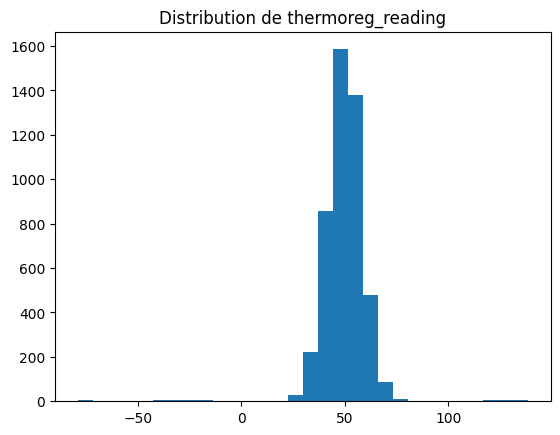


enzyme_activity_index
Moyenne : 103.44
Médiane : 101.00
Écart-type : 38.81
Asymétrie : 1.84
Distribution fortement asymétrique


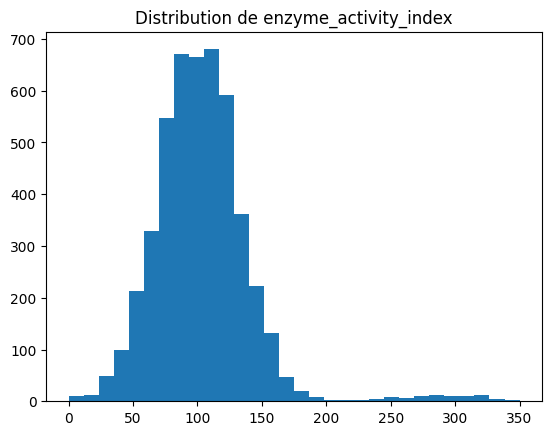


dual_lobe_signal
Moyenne : 2.01
Médiane : 2.50
Écart-type : 3.00
Asymétrie : -0.30
Distribution ≈ symétrique


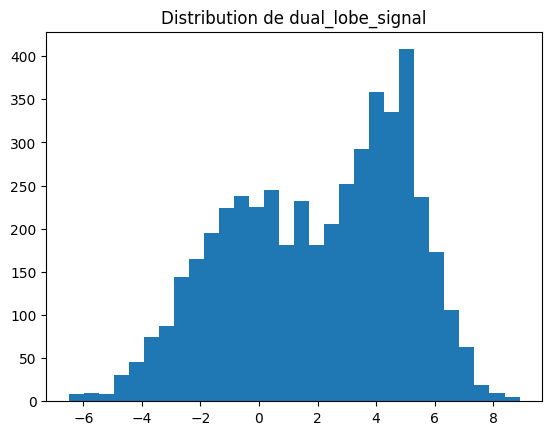


stress_variability
Moyenne : 0.02
Médiane : 0.00
Écart-type : 4.99
Asymétrie : -0.01
Distribution ≈ symétrique


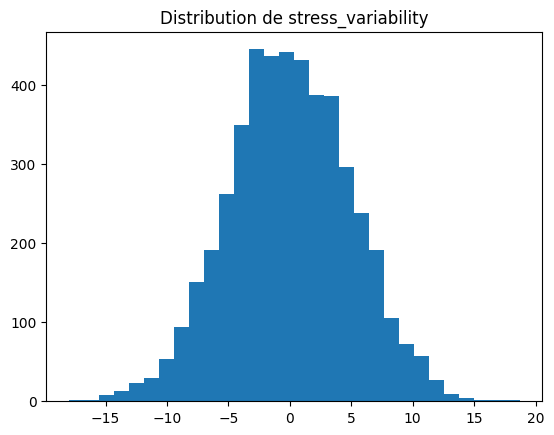


activity_score
Moyenne : 2.97
Médiane : 3.00
Écart-type : 1.29
Asymétrie : 0.08
Distribution ≈ symétrique


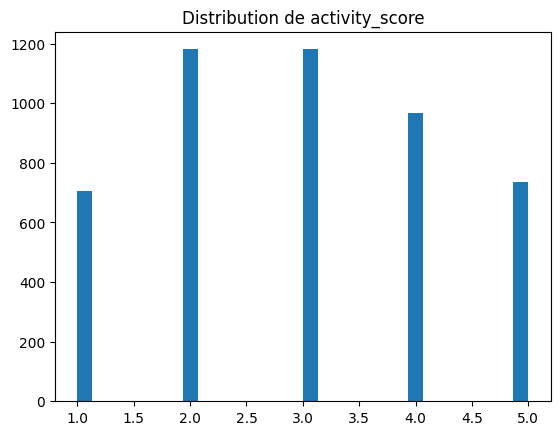


fasting_flag
Moyenne : 0.40
Médiane : 0.00
Écart-type : 0.49
Asymétrie : 0.39
Distribution ≈ symétrique


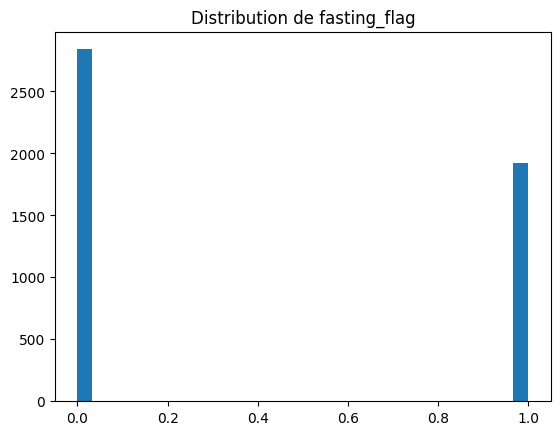


health_outcome
Moyenne : 0.50
Médiane : 0.00
Écart-type : 0.50
Asymétrie : 0.00
Distribution ≈ symétrique


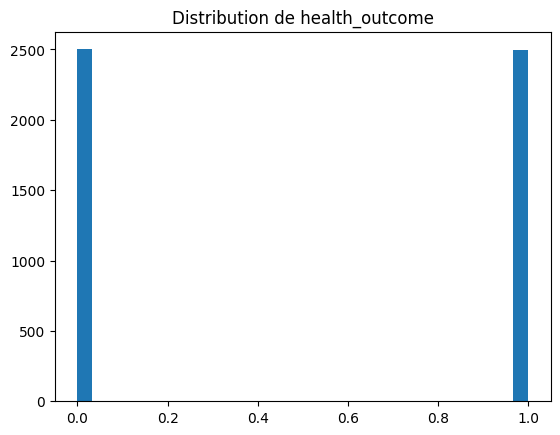

In [12]:
# Analyser les distributions des variables numériques
colonnes_numeriques = donnees_nettoyees.select_dtypes(include=[np.number]).columns

for colonne in colonnes_numeriques:
    valeurs = donnees_nettoyees[colonne].dropna()
    
    print(f"\n{colonne}")
    print(f"Moyenne : {valeurs.mean():.2f}")
    print(f"Médiane : {valeurs.median():.2f}")
    print(f"Écart-type : {valeurs.std():.2f}")
    print(f"Asymétrie : {valeurs.skew():.2f}")
    
    # Interprétation
    asymetrie = valeurs.skew()
    if abs(asymetrie) < 0.5:
        print("Distribution ≈ symétrique")
    elif abs(asymetrie) < 1:
        print("Distribution modérément asymétrique")
    else:
        print("Distribution fortement asymétrique")
    
    # Histogramme
    plt.figure()
    plt.hist(valeurs, bins=30)
    plt.title(f'Distribution de {colonne}')
    plt.show()


6. **Équilibre des classes**

Méthodologie :
J'ai calculé la distribution des classes de la variable cible et le ratio entre la classe majoritaire et minoritaire. Un ratio inférieur à 1.5 indique un dataset équilibré.

Distribution des classes :
health_outcome
0    2501
1    2499
Name: count, dtype: int64
Ratio de déséquilibre : 1.00
Jeu de données équilibré


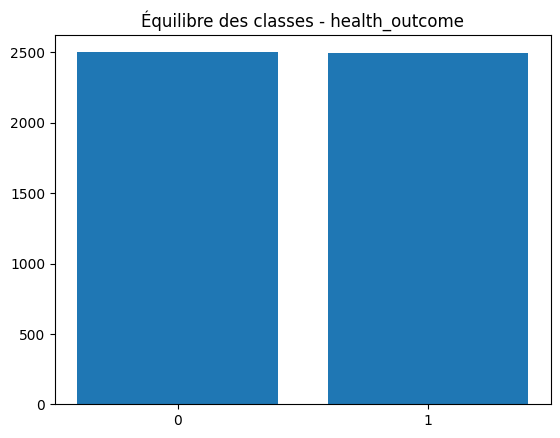

In [13]:
# Analyser la distribution de la variable cible
distribution_classes = donnees_nettoyees['health_outcome'].value_counts()
print("Distribution des classes :")
print(distribution_classes)

# Calculer le ratio de déséquilibre
ratio = distribution_classes.max() / distribution_classes.min()
print(f"Ratio de déséquilibre : {ratio:.2f}")

if ratio < 1.5:
    print("Jeu de données équilibré")
else:
    print("Jeu de données déséquilibré")

# Diagramme en barres
plt.bar(distribution_classes.index.astype(str), distribution_classes.values)
plt.title("Équilibre des classes - health_outcome")
plt.show()


7. **Sauvegarder les données nettoyées**

In [14]:
# Sauvegarder le jeu de données nettoyé
donnees_nettoyees.to_csv('alien_pet_health_cleaned.csv', index=False)

donnees_verification = pd.read_csv('alien_pet_health_cleaned.csv')
print(f"Fichier sauvegardé : {donnees_verification.shape[0]} lignes, {donnees_verification.shape[1]} colonnes")
print("Colonnes :", list(donnees_verification.columns))


Fichier sauvegardé : 5000 lignes, 9 colonnes
Colonnes : ['thermoreg_reading', 'enzyme_activity_index', 'dual_lobe_signal', 'stress_variability', 'habitat_zone', 'activity_score', 'fasting_flag', 'health_outcome', 'calibration_tag']


# Références

https://pandas.pydata.org/docs/

https://matplotlib.org/stable/contents.html

https://seaborn.pydata.org/

# Ressources

Si vous utilisez l'assistance par IA, il est essentiel de documenter minutieusement toutes les interactions. Votre rapport doit spécifier les outils et leurs versions, accompagnés d'une transcription complète de ces interactions. La plupart des plateformes d'IA enregistrent automatiquement les conversations, il est donc conseillé de démarrer une nouvelle conversation spécifiquement pour le devoir et d'utiliser systématiquement ce fil tout au long de votre travail. Assurez-vous que cette conversation reste exclusivement centrée sur le devoir. Incluez la transcription de cette conversation.